In [12]:
%run LanguageModel.py
%run DataLoader.py
%run rnn_utils.py
%run encoder.py
%run decoder.py
%run seq2seq.py
%run model_config.py
%run metrics.py
%run ScorePrinter.py

import numpy as np
import math
import json

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LENGTH = 50

In [14]:
train_dl = DataLoader('train', ('de', 'en'), max_length = MAX_LENGTH, device = device)

In [15]:
val_dl = DataLoader('dev', ('de', 'en'), languageModels = train_dl.languageModels, max_length = MAX_LENGTH, device = device)

In [16]:
lm1 = train_dl.languageModels[train_dl.languages[0]]
lm2 = train_dl.languageModels[train_dl.languages[1]]
model_config = ModelConfig(input_size = lm1.n_tokens, 
                           beam_width = 3, 
                           hidden_size = 250, 
                           output_size = lm2.n_tokens, 
                           rnn_type='lstm', 
                           bidirectional=True, 
                           attention = 'global_context', 
                           score = 'dot', 
                           learning_rate = 3 * 10**(-4),
                           max_length=MAX_LENGTH+2) # +2 for SOS and EOS
#checkpoint = torch.load("./state_dict.tar")
s2s = seq2seq(model_config=model_config, state_dict = None, device = device)

In [17]:
def train_epochs(epochs, print_every=1000):
    n_iters = len(train_dl)
    score_printer = ScorePrinter("Training", [('NLL', loss_metric),('Perplexity', perplexity), ('BLEU', bleu)])

    for epoch in range(1, epochs+1):
        score_printer.startEpoch(epoch)
        idx_permutation = np.random.permutation(len(train_dl))[:100]

        for i, index in enumerate(idx_permutation):
            input_tensor, target_tensor = train_dl.tensorsFromPos(index)

            loss, output_sentence = s2s.train(input_tensor, target_tensor)
            real_target_sentence, estimated_target_sentence = train_dl.real_estimated_sentence(target_tensor, output_sentence)
            score_printer.update(nll = loss, target_length = target_tensor.size(0), real_target_sentence=real_target_sentence, estimated_target_sentence=estimated_target_sentence)
            
            if (i + 1) % print_every == 0:
                score_printer.printAvg(print_every, last = 200)
        
        #score_printer.printAvg(len(train_dl))
        val_avg_score = validate(100)
        train_avg_score = score_printer.getAvgScores()
        with open('./Validation_scores' + str(epoch) + '.txt', 'a') as validation_scores, open('./Training_scores' + str(epoch) + '.txt', 'a') as training_scores:
            validation_scores.write(json.dumps(val_avg_score) + '\n')
            training_scores.write(json.dumps(train_avg_score) + '\n')
        #print(f"Val_avg_score: {val_avg_score}, train_avg_score: {train_avg_score}")
        score_printer.endEpoch(epoch)
        
        torch.save(s2s.state_dict(),"./state_dict_"+str(epoch)+".tar")

In [18]:
def validate(n = None):
    score_printer = ScorePrinter("Validation", [('NLL normalized', loss_metric),('Perplexity', perplexity), ('BLEU', bleu)])
    n = n or len(val_dl)
    idx_permutation_val = np.random.permutation(len(val_dl))[:n]
    score_printer.beginMeasurements()
    for j, val_index in enumerate(idx_permutation_val):
        input_tensor_val, target_tensor_val = val_dl.tensorsFromPos(val_index)
        loss, output_sentence = s2s.evaluate(input_tensor_val, target_tensor_val)
        real_target_sentence, estimated_target_sentence = val_dl.real_estimated_sentence(target_tensor_val, output_sentence)
        print(f"real : {real_target_sentence}, est : {estimated_target_sentence}")
        score_printer.update(nll = loss, target_length = target_tensor_val.size(0), real_target_sentence  = real_target_sentence, estimated_target_sentence = estimated_target_sentence)
    score_printer.printAvg(showCount = False)
    return score_printer.getAvgScores()

In [19]:
train_epochs(20, print_every=5)



Epoch 1 started
 
[Training] 5 examples /  NLL: 10.66 Perplexity: 42536.24 BLEU[0]: 0.00	BLEU[1]: 0.00	BLEU[2]: 0.00	BLEU[3]: 0.00	BLEU[4]: 0.00
 
[Training] 10 examples /  NLL: 10.65 Perplexity: 42047.14 BLEU[0]: 0.00	BLEU[1]: 3.10	BLEU[2]: 0.00	BLEU[3]: 0.00	BLEU[4]: 0.00
 
[Training] 15 examples /  NLL: 9.66 Perplexity: 33568.58 BLEU[0]: 0.00	BLEU[1]: 8.05	BLEU[2]: 1.67	BLEU[3]: 0.00	BLEU[4]: 0.00
 
[Training] 20 examples /  NLL: 8.87 Perplexity: 28763.80 BLEU[0]: 0.00	BLEU[1]: 14.24	BLEU[2]: 1.88	BLEU[3]: 0.00	BLEU[4]: 0.00
 
[Training] 25 examples /  NLL: 9.16 Perplexity: 29103.79 BLEU[0]: 0.00	BLEU[1]: 12.12	BLEU[2]: 1.50	BLEU[3]: 0.00	BLEU[4]: 0.00
 
[Training] 30 examples /  NLL: 8.35 Perplexity: 24980.94 BLEU[0]: 0.00	BLEU[1]: 18.94	BLEU[2]: 1.25	BLEU[3]: 0.00	BLEU[4]: 0.00
 
[Training] 35 examples /  NLL: 8.02 Perplexity: 22098.24 BLEU[0]: 0.00	BLEU[1]: 21.56	BLEU[2]: 2.61	BLEU[3]: 0.00	BLEU[4]: 0.00


KeyboardInterrupt: 

In [9]:
from IPython.display import display, Markdown
def print_validation(position):
    input_sentence = val_dl.sentenceFromTensor('de', val_dl.tensorsFromPos(position)[0])
    display(Markdown('**Eingabe**'))
    display(Markdown(' '.join(input_sentence)))
    prediction = s2s.predict(val_dl.tensorsFromPos(position)[0])
    output_sentence = val_dl.sentenceFromTensor('en', prediction[0])
    display(Markdown('**Ausgabe**'))
    display(Markdown(' '.join(output_sentence)))
    attentions = torch.stack([tensor.squeeze() for tensor in prediction[2]])
    attentions = attentions.numpy()[:len(output_sentence)-1,:len(input_sentence)]
    display(Markdown('**Attention**'))
    show_attention(input_sentence, output_sentence, attentions)

In [10]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker

def show_attention(input_sentence, output_sentence, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(16, 14), dpi= 80)
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    
    ax.set_xticks(np.arange(len(input_sentence)))
    ax.set_xticklabels(input_sentence, rotation=90)
    ax.set_yticks(np.arange(len(output_sentence[1:])))
    ax.set_yticklabels(output_sentence[1:]) # ignore SOS Token

    plt.show()

**Eingabe**

es gibt außerdem auch einige nette möglichkeiten in der bildung wie sprachen , mathematik oder UNK , wo wir den leuten die möglichkeit des schnellen ausprobierens geben und die ergebnisse sofort sehen wollen . EOS

**Ausgabe**

SOS EOS

**Attention**

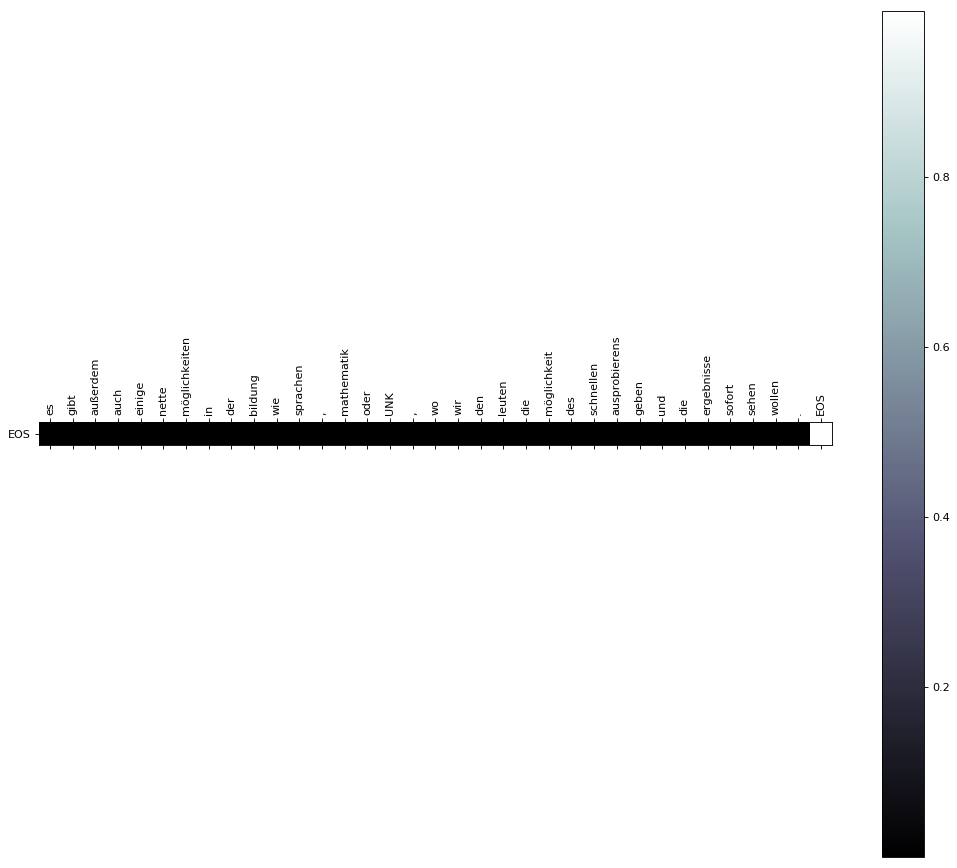

In [11]:
print_validation(19)